In [1]:
import string
from string import digits
import numpy as np
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/drive', force_remount=True)

# DOWNLOADS
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
sw = stopwords.words("english")

########## CONFIG ##########
notebook_drive_path = '/drive/MyDrive/Colab Notebooks/Hermes_reviews_experiment/'
ONLY_NOUNS_FOR_CLUSTERING = True
MAX_DF = 1.0
MIN_DF = 1
EPS = 0.8
MIN_SAMPLES = 2
TARGET_TOPICS = 3
########## CONFIG ##########

Mounted at /drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


1) Loading CSV...
2) Extracting tokens...

Tokens vocabulary:
['air' 'dish' 'experi' 'famili' 'friend' 'guid' 'lawn' 'mainten'
 'monument' 'natur' 'order' 'outdoor' 'picnic' 'place' 'restaur' 'rude'
 'servic' 'staff' 'toilet' 'view' 'waiter']


3) Generating TF-IDF matrix...

Vocabulary Size :  21
Shape of Matrix :  (13, 21)

4) Clustering...

Clusterer: DBSCAN

5)Generating clusters dataframe...


1    6
0    5
2    2
Name: Cluster, dtype: int64


6) Saving clusters csv...

7) Analizing clusters for topics extraction...

Num of clusters (with possible noise cluster = -1): 3
Clusters labels:  [0 1 2]


CLUSTERS:
---------------------
Cluster 0

Tokenizing topics...


Topics:
['experience' 'maintenance' 'order' 'rude' 'service' 'staff' 'toilets'
 'waiter']

Applying LDA...


TOPICS:  ['toilets', 'order', 'staff']
---------------------
---------------------
Cluster 1

Tokenizing topics...


Topics:
['air' 'dishes' 'family' 'friends' 'lawns' 'nature' 'outdoors' 'picnic'
 'place' 'restaura

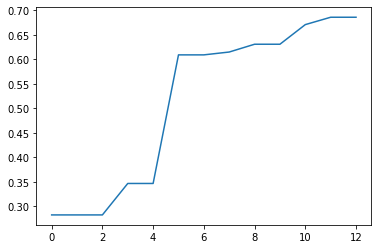


Clusters:


,Review,Cluster,Cluster_topics
0,Why the toilets are always out of order? Very bad experience.,0,"['toilets', 'order', 'staff']"
1,"At the restaurant I ate very well, really good dishes.",1,"['place', 'restaurant', 'family']"
2,"The place is really beautiful, it's full of restaurants and stunning views. I will definitely be back.",1,"['place', 'restaurant', 'family']"
3,"A perfect place for the family, there are vast lawns for picnicking and relaxing outdoors. The perfect place to enjoy nature.",1,"['place', 'restaurant', 'family']"
4,"There are no toilets, the staff are rude and a waiter insulted me.",0,"['toilets', 'order', 'staff']"
5,"The place is great, surrounded by nature, clean air.",1,"['place', 'restaurant', 'family']"
6,"In the restaurant you eat very well, I will also bring my friends",1,"['place', 'restaurant', 'family']"
7,"Rude staff, will never go back, bad service.",0,"['toilets', 'order', 'staff']"
8,"Toilets out of order, no maintenance, bad.",0,"['toilets', 'order', 'staff']"
9,"The monument is well cared for, fantastic, the guides very well prepared.",2,"['guide', 'guides', 'monument']"


In [2]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


def filter_nouns(sentence):
  tokenized = nltk.word_tokenize(sentence)
  nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')]
  return nouns


def clean(sentence):
    no_punctuation = re.sub(r"[,.'’‘\"“”:;/*()%@#?§£Є°#\\^\+\-ç!&$]+\ *", " ", sentence.lower())
    no_escape = re.sub(r'(\r\n|\n|\r|\t)', ' ', no_punctuation)
    no_urls = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ', no_escape)
    no_emoji = re.sub(r"["u"\U0001F600-\U0001F64F"
                  u"\U0001F300-\U0001F5FF"  
                  u"\U0001F680-\U0001F6FF"  
                  u"\U0001F1E0-\U0001F1FF" 
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", no_urls, flags=re.UNICODE)
    only_alpha = re.sub("[^a-z]+", " ", no_emoji)
    no_digits = only_alpha.translate(str.maketrans('', '', digits))
    return no_digits


def tokenize(sentence):
    cleaned = clean(sentence)

    if ONLY_NOUNS_FOR_CLUSTERING:
      tokens = filter_nouns(cleaned)
    else:
      tokens = cleaned.split()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in sw]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens


def tokenize_topics(sentence):
    cleaned = clean(sentence)
    only_nouns = filter_nouns(cleaned)
    tokens = [word for word in only_nouns if word not in sw]
    return tokens


print('1) Loading CSV...')
df = pd.read_csv(notebook_drive_path + 'test.csv', index_col=0)

print('2) Extracting tokens...')
cv = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF, analyzer=tokenize)
x_cv = cv.fit_transform(df['Review']).toarray()

print('\nTokens vocabulary:')
print(cv.get_feature_names_out())
print('\n')

print('3) Generating TF-IDF matrix...\n')
tfidf_converter = TfidfTransformer()
x_tf_matrix = tfidf_converter.fit_transform(x_cv).toarray()

print('Vocabulary Size : ', len(cv.get_feature_names_out()))
print('Shape of Matrix : ', x_tf_matrix.shape)

print('\n4) Clustering...')

clusterer = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='cosine', n_jobs=-1)

clusterer_name = 'DBSCAN'
print('\nClusterer: ' + clusterer_name)
result = clusterer.fit_predict(x_tf_matrix)

print('\n5)Generating clusters dataframe...')
clusters_df = pd.DataFrame(columns=['Review', 'Cluster'], data=zip(df['Review'], result))
print('\n')
print(clusters_df['Cluster'].value_counts())
print('\n')
print('6) Saving clusters csv...')
clusters_df.to_csv(notebook_drive_path + clusterer_name + '_test_clusters.csv')

print('\n7) Analizing clusters for topics extraction...')

clusters = clusters_df['Cluster'].unique()
print('\nNum of clusters (with possible noise cluster = -1):', len(clusters))
print('Clusters labels: ', clusters)
print('\n')

print('CLUSTERS:')

clusters_df['Cluster_topics'] = None

clusters_topics = dict()

for cluster in clusters:
  topics = []

  print('---------------------')
  print('Cluster ' + (str(cluster) + '\n' if cluster != -1 else 'NOISY:\n'))
  cluster_reviews = clusters_df.query("Cluster == " + str(cluster))
  reviews = cluster_reviews['Review'].tolist()

  print('Tokenizing topics...\n')
  tfidf = TfidfVectorizer(tokenizer = tokenize_topics)
  data = tfidf.fit_transform(reviews) 
  terms = tfidf.get_feature_names_out()
  print('\nTopics:')
  print(terms)

  print('\nApplying LDA...\n')
  model=LatentDirichletAllocation(n_components=1)
  model.fit_transform(data)
  lda_components=model.components_

  for index, component in enumerate(lda_components):
      zipped = zip(terms, component)
      top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:TARGET_TOPICS]
      top_terms_list=list(dict(top_terms_key).keys())
      topics = topics + top_terms_list
     
  print("\nTOPICS: ", topics)
  clusters_topics[cluster] = topics
  print('---------------------')

clusters_df['Cluster_topics'] = clusters_df.apply(lambda row: clusters_topics[row['Cluster']], axis = 1)

print('\n8) Saving labeled clusters csv...')
clusters_df.to_csv(notebook_drive_path + clusterer_name + '_test_clusters_LABELED.csv')

print('\nε estimation\n')

#Calculate the average distance between each point in the data set and its nearest neighbors
neighbors = NearestNeighbors(n_neighbors=MIN_SAMPLES,  metric='cosine')
neighbors_fit = neighbors.fit(x_tf_matrix)
distances, indices = neighbors_fit.kneighbors(x_tf_matrix)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

print('\nClusters:')
pd.set_option('display.max_colwidth', None)
df = pd.read_csv(notebook_drive_path + 'DBSCAN_test_clusters_LABELED.csv', index_col=0)
df